## How do Twitter users really feel?

#### Introduction

In this project I am using unsupervised learning techniques to analyze a dataset of tweets. The dataset from Kaggle has been critisised for being poorly labelled, so in this project I apply Non-Negative Matrix Factorization (NMF) for topic modeling and VADER for sentiment analysis, aiming to explore patterns and relationships in the data without relying on labels. 

The primary goal is to uncover underlying topics within the tweet dataset and analyze how sentiment varies across these topics. This is interesting as it gives a 2D mapping perspective on the sentiment across the ~7300 tweets in the dataset. Given content recommendation algorithms select the content we see, such mappings can be very useful to visualise objectively how likely people are to express a certain sentiment or otherwise, and how this changes between topics. This could have practical uses in industry, for example, uploading datasets containing all posts during a certain day, to compare the sentiment users think people have based on their feeds, versus the one that is in actuality being communicated post-wise.

#### The data

The dataset used in this project is from the Twitter Entity Sentiment Analysis available on Kaggle. It consists of over 70,000 tweets, making it a rich source for sentiment analysis and topic modeling - the training document has over 7,300 tweets and is the one used in this project primarily. The dataset is sequential in nature, as it consists of textual data (tweets) along with labels like sentiment categories ("positive," "negative," "neutral," etc.). The data is structured with several columns: tweet ID, tweet text, category, and sentiment label. Each row represents an individual tweet with its associated metadata, such as the sentiment score and topic. The text column contains the actual tweets, while the other columns provide insights like category labels and sentiment, enabling the exploration of sentiment distribution and its relation to various topics. The total size of the data is large but manageable, and it was utilized for topic modeling, sentiment clustering, and exploratory analysis in this project.



In [18]:
# Loading libraries (required some installations)

import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
import umap
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.cluster import KMeans

#### Data cleaning and exploratory data analysis


The EDA was conducted to understand the characteristics of tweet data and guide subsequent modeling decisions based on what this looked like. The goal was to clean the data, assess word usage, and visualise patterns that might inform topic and sentiment detection - for example, to help outline the use of TF IDF.

                                               Tweet
0  im getting on borderlands and i will murder yo...
1  I am coming to the borders and I will kill you...
2  im getting on borderlands and i will kill you ...
3  im coming on borderlands and i will murder you...
4  im getting on borderlands 2 and i will murder ...
                                               Tweet  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   

                    cleaned_tweet  
0    im getting borderland murder  
1              coming border kill  
2      im getting borderland kill  
3     im coming borderland murder  
4  im getting borderland 2 murder  
Missing values in the 'Tweet' column:
Tweet            0
cleaned_tweet    0
dtype: int64


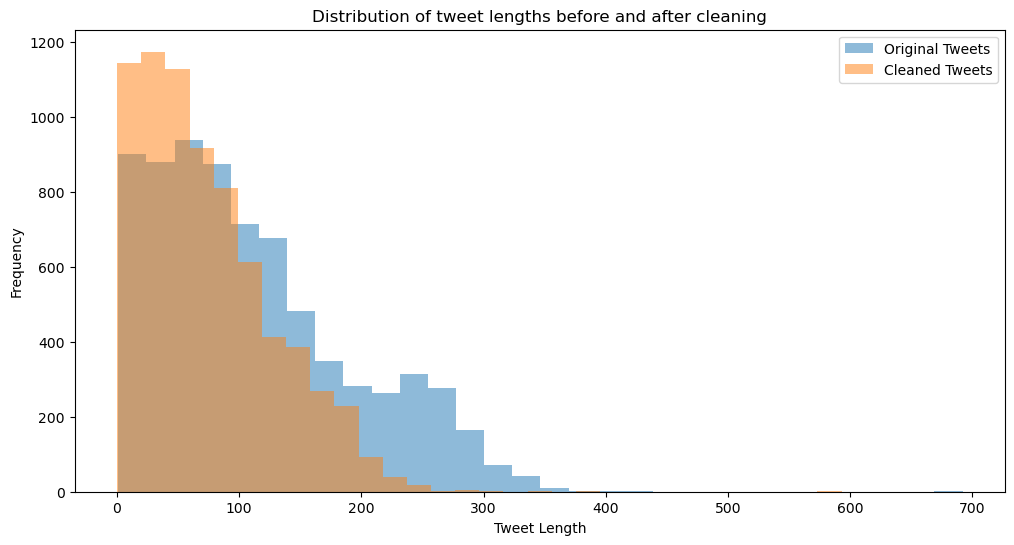

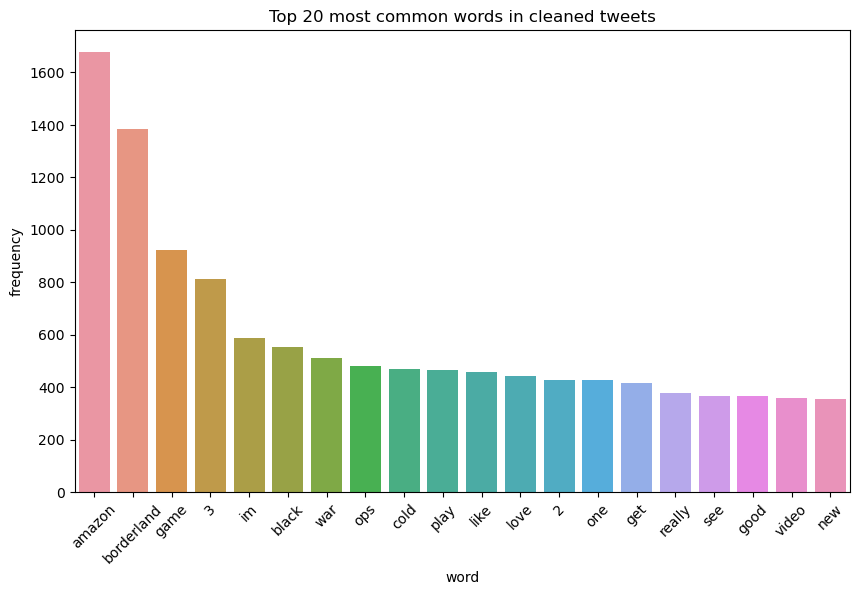

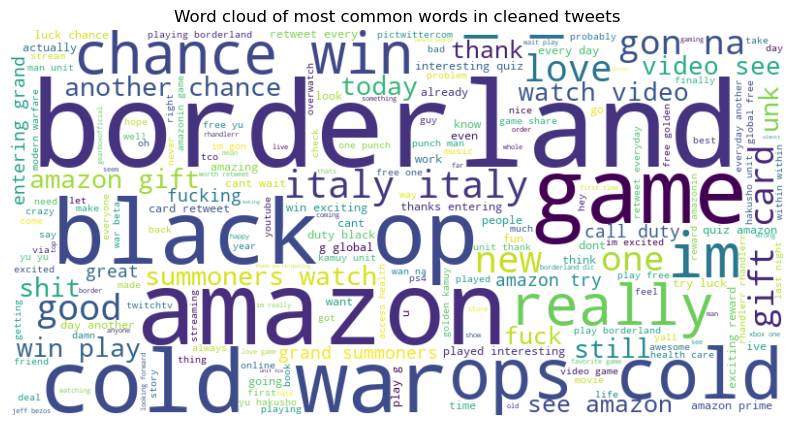

/Users/alex/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


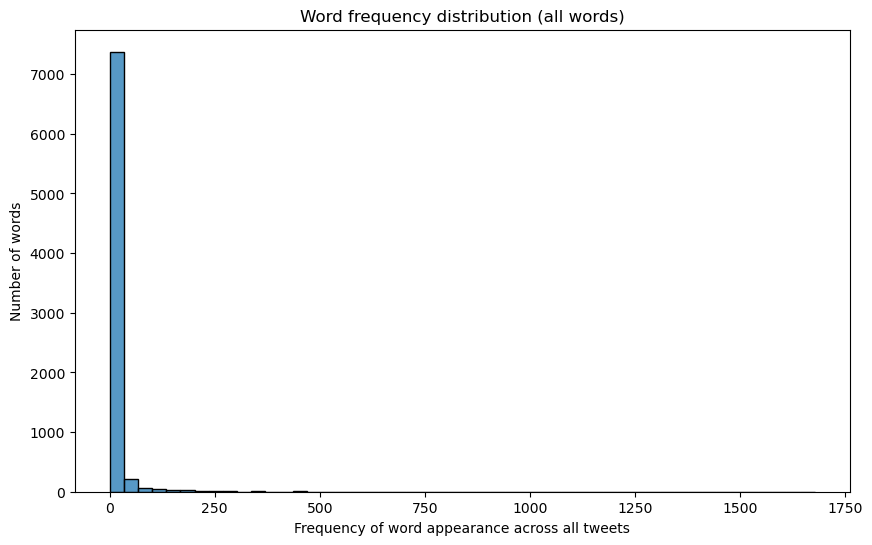

/Users/alex/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


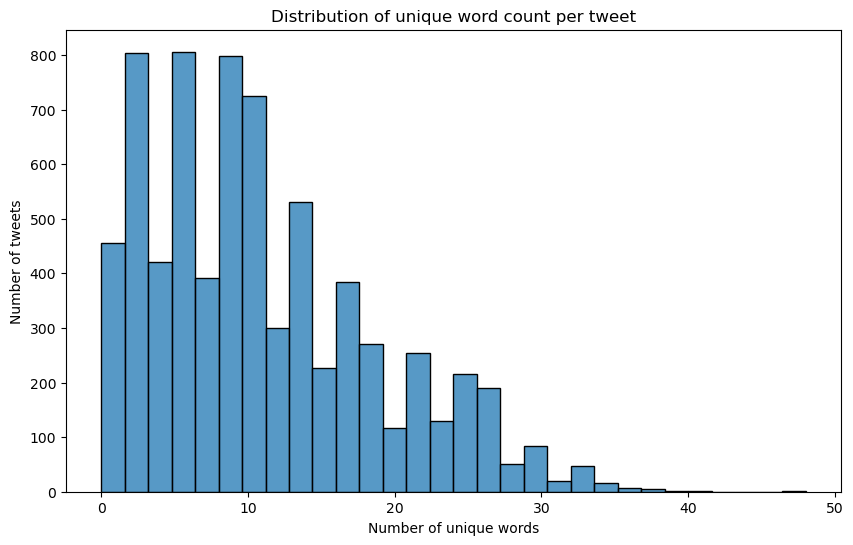

/Users/alex/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


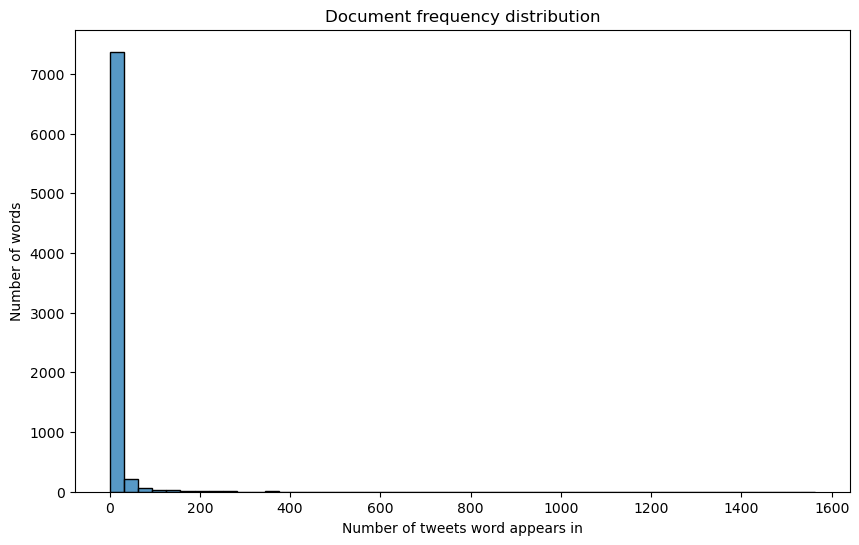

            word  document_frequency
5012      amazon                1562
3     borderland                1340
273         game                 805
42             3                 761
905        black                 523
0             im                 512
509          war                 494
3573         ops                 459
3576        cold                 455
235         play                 439


In [12]:
# Loading stopwords, lemmatizer, and spaCy model
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Loading the data set then doing basic preprocessing
train_df = pd.read_csv('/Users/alex/Desktop/github_projects/sentiment-map/twitter-data/twitter_training.csv', header=None)

train_df = train_df[[3]].copy()  
train_df.columns = ['Tweet']  
train_df.dropna(subset=['Tweet'], inplace=True)
print(train_df.head())

def preprocess_tweet(text):
    if isinstance(text, str):  
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\@\w+|\#', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = text.lower()
        
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        return ' '.join(tokens)
    else:
        return '' 
train_df['cleaned_tweet'] = train_df['Tweet'].apply(preprocess_tweet)

print(train_df[['Tweet', 'cleaned_tweet']].head())

# Additional EDA 

print("Missing values in the 'Tweet' column:")
print(train_df.isnull().sum())

# EDA 1 : Basic statistics of the tweet lengths before and after cleaning
train_df['tweet_length'] = train_df['Tweet'].apply(lambda x: len(str(x)))
train_df['cleaned_tweet_length'] = train_df['cleaned_tweet'].apply(lambda x: len(str(x)))

# Plot distributions of tweet lengths
plt.figure(figsize=(12, 6))
plt.hist(train_df['tweet_length'], bins=30, alpha=0.5, label='Original Tweets')
plt.hist(train_df['cleaned_tweet_length'], bins=30, alpha=0.5, label='Cleaned Tweets')
plt.legend(loc='upper right')
plt.title('Distribution of tweet lengths before and after cleaning')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

# EDA 2: Most common words in the cleaned tweets
all_words = ' '.join(train_df['cleaned_tweet']).split()
word_freq = Counter(all_words)

common_words = word_freq.most_common(20)
common_words_df = pd.DataFrame(common_words, columns=['word', 'frequency'])

plt.figure(figsize=(10, 6))
sns.barplot(x='word', y='frequency', data=common_words_df)
plt.xticks(rotation=45)
plt.title('Top 20 most common words in cleaned tweets')
plt.show()

# EDA 3: Word Cloud of the Most Common Words
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title('Word cloud of most common words in cleaned tweets')
plt.show()

# EDA 4: Word frequency distribution

all_words = ' '.join(train_df['cleaned_tweet']).split()
word_freq = Counter(all_words)

word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

plt.figure(figsize=(10, 6))
sns.histplot(word_freq_df['frequency'], bins=50, kde=False)
plt.title('Word frequency distribution (all words)')
plt.xlabel('Frequency of word appearance across all tweets')
plt.ylabel('Number of words')
plt.show()

# EDA 5: Unique word count per tweet

train_df['unique_word_count'] = train_df['cleaned_tweet'].apply(lambda x: len(set(x.split())))

plt.figure(figsize=(10, 6))
sns.histplot(train_df['unique_word_count'], bins=30, kde=False)
plt.title('Distribution of unique word count per tweet')
plt.xlabel('Number of unique words')
plt.ylabel('Number of tweets')
plt.show()

# EDA 5: Document frequency 

def get_document_frequency(tweets):
    df_counter = Counter()
    for tweet in tweets:
        words_in_tweet = set(tweet.split())  
        df_counter.update(words_in_tweet)
    return df_counter

document_freq = get_document_frequency(train_df['cleaned_tweet'])

doc_freq_df = pd.DataFrame(document_freq.items(), columns=['word', 'document_frequency']).sort_values(by='document_frequency', ascending=False)

plt.figure(figsize=(10, 6))
sns.histplot(doc_freq_df['document_frequency'], bins=50, kde=False)
plt.title('Document frequency distribution')
plt.xlabel('Number of tweets word appears in')
plt.ylabel('Number of words')
plt.show()

# Top 10 words in terms of document frequency
print(doc_freq_df.head(10))  

#### Steps taken, discussion and findings:

Text preprocessing - the dataset was cleaned to remove noise (URLs, hashtags, punctuation) and tokenised. Lemmatisation ensured word normalisation. This step was essential to enhance the quality of inputs for NMF and VADER. One row (originally 7334) was removed due to the prescence of characters that could not be tokenised by the system - given neither row transmitted content in English it wasn't deemed to have an impact on the project. 

Tweet length analysis - a comparison of tweet lengths before and after cleaning highlighted the impact of preprocessing. Short tweets were common, indicating the need for handling sparse data when vectorising.

Word frequency - by identifying the most common words (e.g., "game," "love," "new"), we observed a high occurrence of words related to gaming. This guided topic modeling decisions.

Word cloud & distribution - the word cloud visualisation further emphasized dominant words, while frequency plots showed the imbalance of word appearance, justifying the use of TF-IDF for weighting terms in modeling.

### Process and model justification

I addressed missing values by removing or replacing them, ensuring no data distortion. After cleaning the tweets, tokenisation and lemmatisation were applied to normalise the text.

Model selection:

NMF: I chose Non-Negative Matrix Factorization (NMF) for topic modeling because it is well-suited for handling sparse data like tweets. NMF can reveal interpretable topics without requiring labeled data, which aligns with the project’s unsupervised approach.

VADER sentiment analysis: VADER was selected due to its efficiency in analysing sentiment in social media text. It is designed to capture subtle sentiments in short and noisy text, making it ideal for tweet data.

Dimensionality reduction: We used both t-SNE and UMAP for visualising tweet clusters by topic and sentiment. These methods were chosen for their ability to reduce high-dimensional data and reveal patterns in a 2D space, highlighting the relationships between topics and sentiment scores.


#### More background - the choice of NMF with TF IDF

TF-IDF is simple and works well with matrix factorisation techniques like NMF because it results in a sparse matrix (most values are zero), which is easier for NMF to handle efficiently.
NMF relies on linear algebra (decomposition of matrices) to uncover latent structures (topics), and TF-IDF naturally fits this framework.

TF-IDF emphasises the importance of terms within individual documents (tweets) by considering both the frequency of terms in a document and how rare those terms are across the corpus.
This approach makes it easier to uncover topic-specific words (e.g., words that appear frequently in one set of tweets but rarely in others), which is essential for effective topic modeling.

Furthermore, the results of NMF with TF-IDF are generally more interpretable. The topics are represented as weighted sums of words, and these weights directly correspond to the importance of those words in the context of each topic.
The output from TF-IDF + NMF is easy to analyze because each document (tweet) gets a clear topic distribution, and each topic is represented by a list of distinct, meaningful words.

Tweets tend to be short and noisy, meaning they often contain many words that don't appear across the entire corpus. TF-IDF naturally produces a sparse matrix that efficiently represents the data.
NMF works better with sparse data, which makes TF-IDF a better fit for topic modeling on short texts like tweets.


Topic 0:
im like shit really time play dont fucking new look
Topic 1:
dead red redemption redeeming online time story thing pictwittercom live
Topic 2:
unk happy storeplaystationcom wow nice birthday better wtf interesting real
Topic 3:
love new guy world warcraft legend fortnite borderland playing stream
Topic 4:
fuck fucking dont overwatch yall ps5 holy oh yes fifa
Topic 5:
good look wow news luck feel day morning pretty borderland
Topic 6:
player ban battlefield occurred bf4dbcom pubg bf4dbcomplayerban100 bf4db com 100
Topic 7:
game best play fix video played wait year fun ive


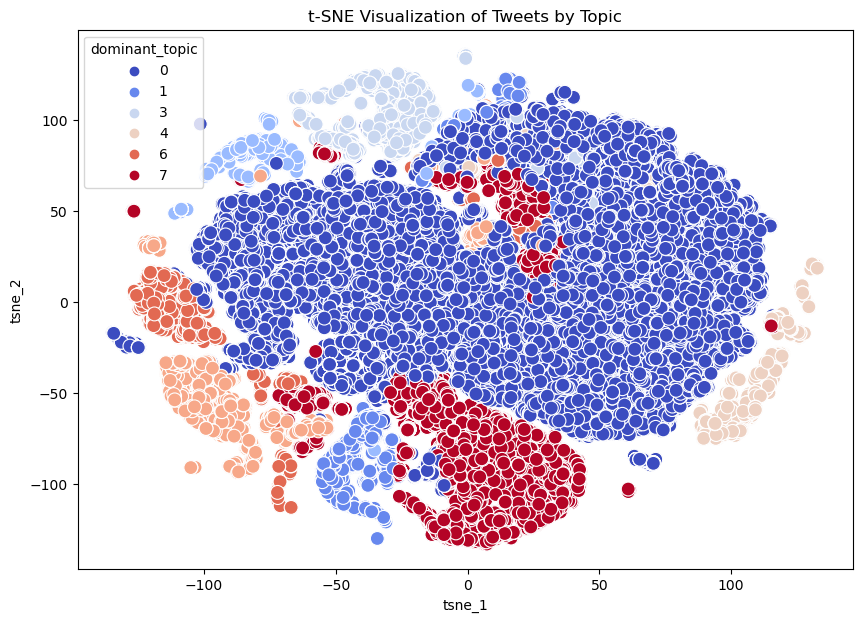

/Users/alex/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


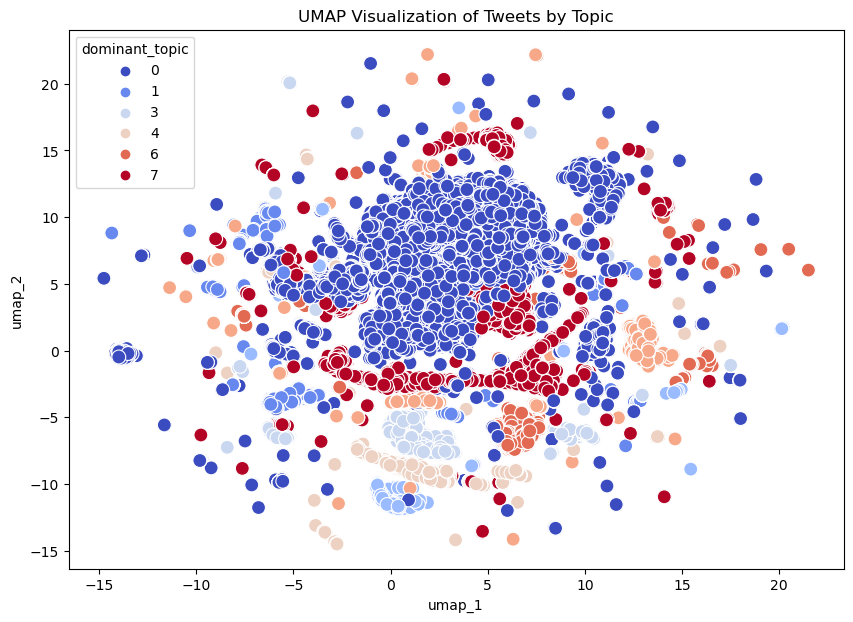

/Users/alex/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


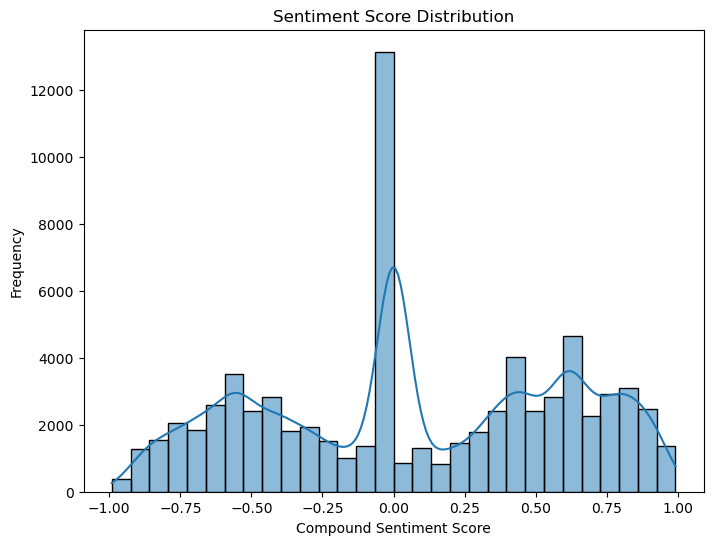

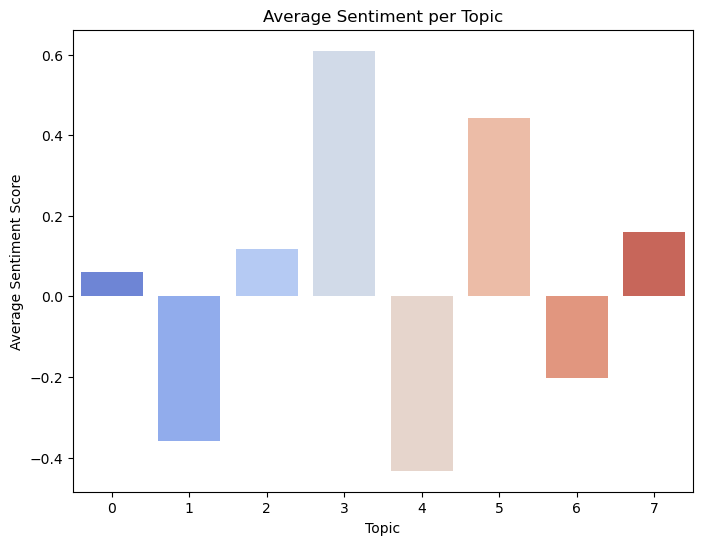

In [13]:
train_df = pd.read_csv('/Users/alex/Desktop/github_projects/sentiment-map/cleaned_twitter_training.csv')
train_df['cleaned_tweet'] = train_df['cleaned_tweet'].fillna('')

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')  # Increase max_features if needed
tfidf_matrix = tfidf_vectorizer.fit_transform(train_df['cleaned_tweet'])

# Applying NMF for topic modeling
n_components = 8 
nmf_model = NMF(n_components=n_components, random_state=42)
W = nmf_model.fit_transform(tfidf_matrix)
H = nmf_model.components_ 

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out(), no_top_words)
train_df['dominant_topic'] = W.argmax(axis=1)

# Analysing how much each tweet contributes to each topic by saving full topic contribution matrix per tweet
topic_contributions = pd.DataFrame(W, columns=[f'Topic_{i+1}' for i in range(n_components)])
train_df = pd.concat([train_df, topic_contributions], axis=1)

# Reducing the tweet vectors (W) to 2D to visualize clusters using t-SNE dimensionality reduction
tsne_model = TSNE(n_components=2, random_state=42)
tsne_values = tsne_model.fit_transform(W)
train_df['tsne_1'] = tsne_values[:, 0]
train_df['tsne_2'] = tsne_values[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='dominant_topic', data=train_df, palette='coolwarm', s=100)
plt.title('t-SNE Visualization of Tweets by Topic')
plt.show()

# Using UMAP for better global structure visualization
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_values = umap_model.fit_transform(W)
train_df['umap_1'] = umap_values[:, 0]
train_df['umap_2'] = umap_values[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(x='umap_1', y='umap_2', hue='dominant_topic', data=train_df, palette='coolwarm', s=100)
plt.title('UMAP Visualization of Tweets by Topic')
plt.show()

# Sentiment analysis using VADER
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return analyzer.polarity_scores(text)
train_df['sentiment'] = train_df['cleaned_tweet'].apply(get_sentiment)
train_df['sentiment_compound'] = train_df['sentiment'].apply(lambda x: x['compound'])

plt.figure(figsize=(8, 6))
sns.histplot(train_df['sentiment_compound'], bins=30, kde=True)
plt.title('Sentiment Score Distribution')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Correlation between sentiment and topics - calculating average sentiment for each of the topics
avg_sentiment_per_topic = train_df.groupby('dominant_topic')['sentiment_compound'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x=avg_sentiment_per_topic.index, y=avg_sentiment_per_topic.values, palette='coolwarm')
plt.title('Average Sentiment per Topic')
plt.xlabel('Topic')
plt.ylabel('Average Sentiment Score')
plt.show()

train_df.to_csv('/Users/alex/Desktop/github_projects/sentiment-map/twitter_training_with_topics_and_sentiment.csv', index=False)


/Users/alex/miniconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


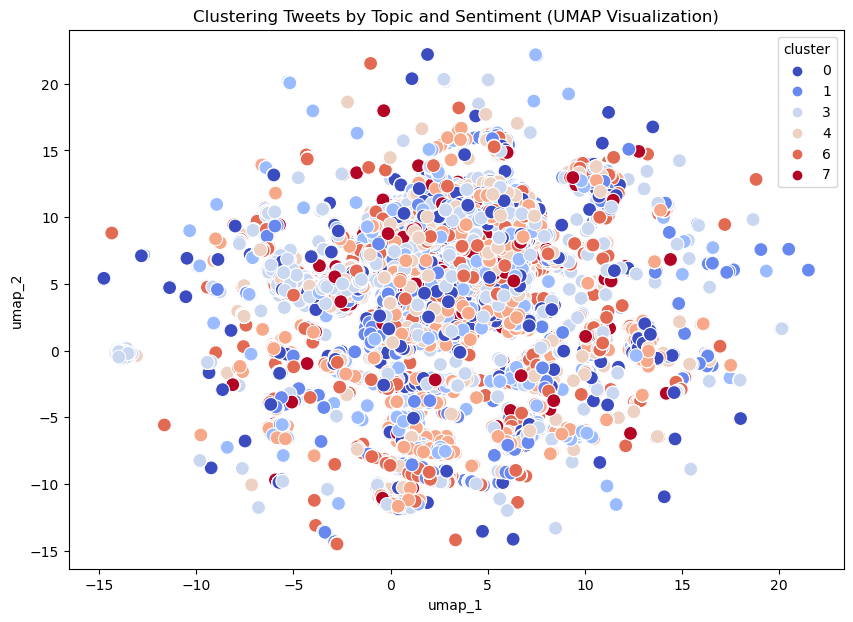

In [14]:
# Combining topic contributions and sentiment score
combined_features = pd.concat([topic_contributions, train_df[['sentiment_compound']]], axis=1)

# Using K-Means to cluster tweets
kmeans = KMeans(n_clusters=8, random_state=42)
train_df['cluster'] = kmeans.fit_predict(combined_features)

# Visualising the clusters in 2D space using UMAP
plt.figure(figsize=(10, 7))
sns.scatterplot(x='umap_1', y='umap_2', hue='cluster', data=train_df, palette='coolwarm', s=100)
plt.title('Clustering Tweets by Topic and Sentiment (UMAP Visualization)')
plt.show()


/Users/alex/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


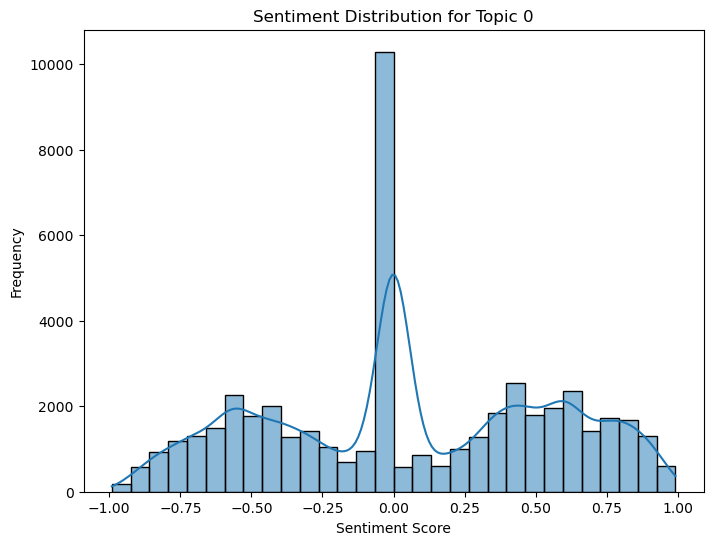

/Users/alex/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


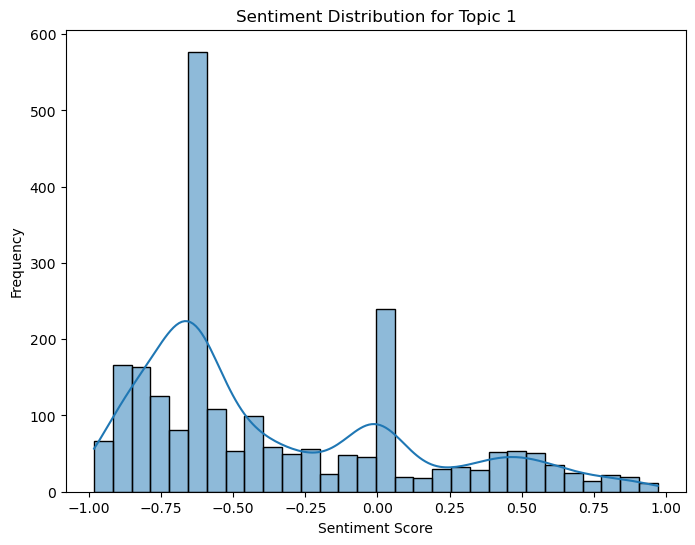

/Users/alex/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


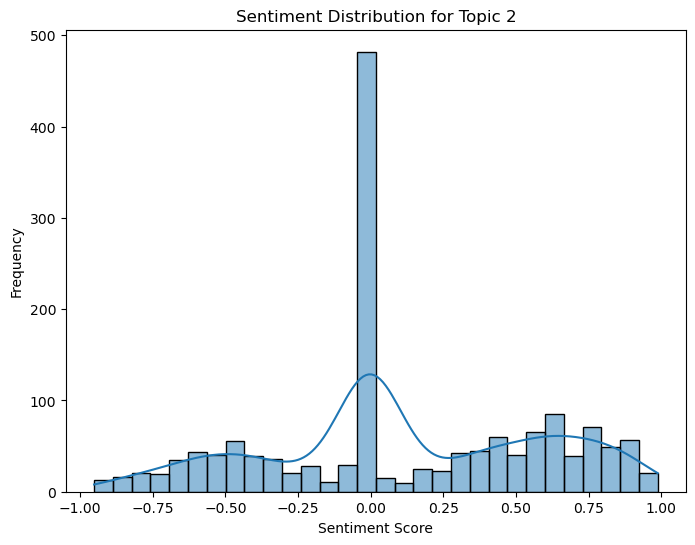

/Users/alex/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


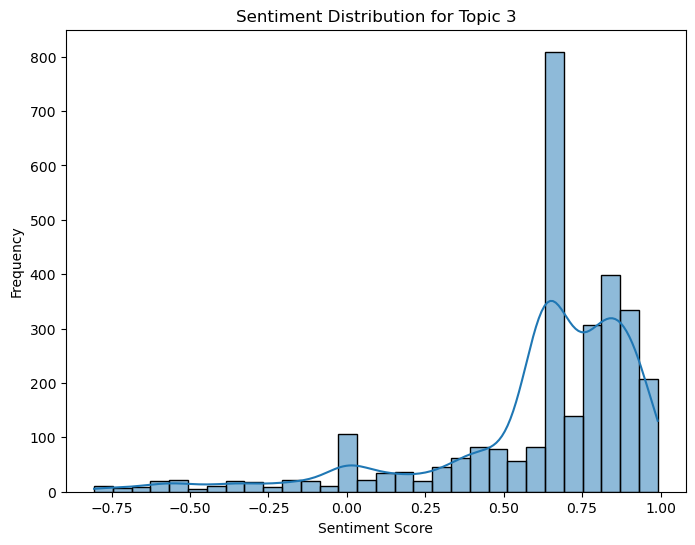

/Users/alex/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


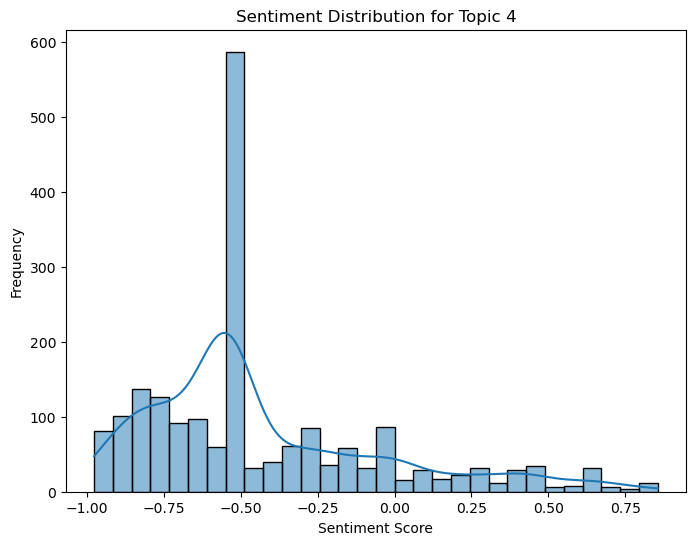

/Users/alex/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


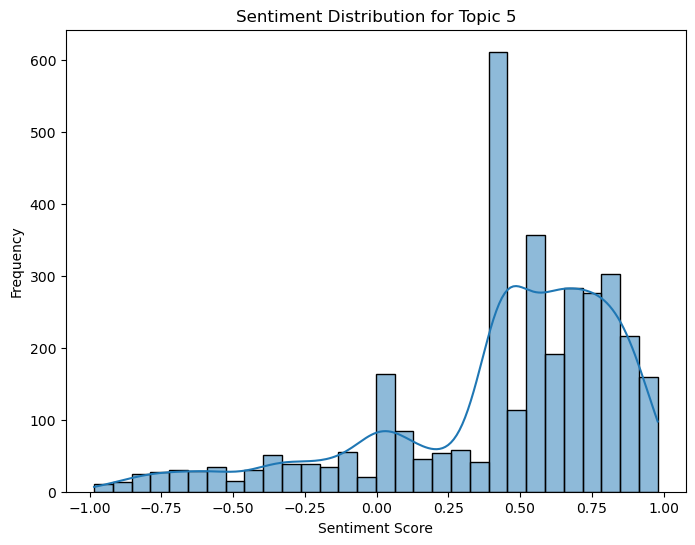

/Users/alex/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


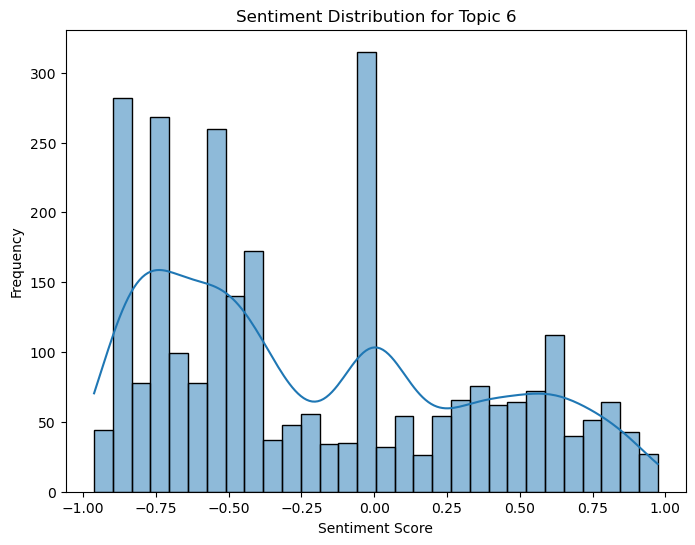

/Users/alex/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


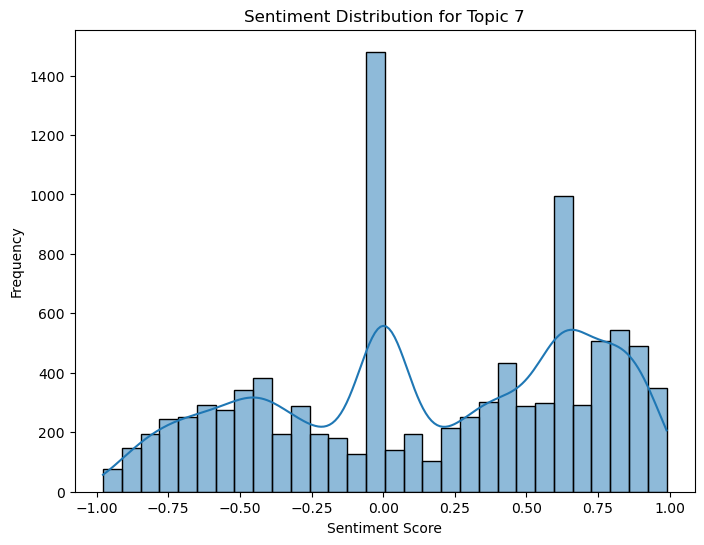

In [15]:
for topic in range(n_components):
    plt.figure(figsize=(8, 6))
    sns.histplot(train_df[train_df['dominant_topic'] == topic]['sentiment_compound'], bins=30, kde=True)
    plt.title(f'Sentiment Distribution for Topic {topic}')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.show()


In [16]:
# Filter for strongly positive or negative tweets
strong_positive_tweets = train_df[train_df['sentiment_compound'] > 0.7]
strong_negative_tweets = train_df[train_df['sentiment_compound'] < -0.7]

# Viewing the strongly positive tweets per topic
for topic in range(n_components):
    positive_tweets_in_topic = strong_positive_tweets[strong_positive_tweets['dominant_topic'] == topic]
    print(f'Topic {topic} - Strongly Positive Tweets:\n', positive_tweets_in_topic['cleaned_tweet'].head())

# Viewing the strongly negative tweets per topic
for topic in range(n_components):
    negative_tweets_in_topic = strong_negative_tweets[strong_negative_tweets['dominant_topic'] == topic]
    print(f'Topic {topic} - Strongly Negative Tweets:\n', negative_tweets_in_topic['cleaned_tweet'].head())


Topic 0 - Strongly Positive Tweets:
 6     spent hour making something fun dont know huge...
7     spent couple hour something fun dont know im h...
8     spent hour something fun dont know im huge bor...
9     spent hour making something fun dont know huge...
10    2010 spent hour making something fun dont know...
Name: cleaned_tweet, dtype: object
Topic 1 - Strongly Positive Tweets:
 804     1 warframe 2 dead daylight 3 overwatch 4 minec...
3549    well upped fov 10 mm definitely feel hit fps b...
4727    amazon seller cheap sport collectible fortt32v...
5864    longwu woman type elegant body comfortable cas...
6577    thanks red summoners watch video pay 100 amazo...
Name: cleaned_tweet, dtype: object
Topic 2 - Strongly Positive Tweets:
 244                 unk 3 good far guardian 2 always fav
326    big special congratulation fellow family unk w...
673     h0rny friend also wonderful fantastic artist unk
674       h0rny friend though also successful artist unk
710    borderland rpg

### Looking to improve the model

Though the results show promising signs of clustering, the below looked to experiment with improving the model by increasing n_components, to see if we get more distinct topics.

Topic 0:
im like really time play new look dont playing people
Topic 1:
dead red redemption redeeming online time story thing pictwittercom live
Topic 2:
unk happy storeplaystationcom wow wtf better nice birthday interesting depot
Topic 3:
love guy new world warcraft fortnite legend borderland gta god
Topic 4:
fuck fucking dont overwatch yall ps5 holy yes oh fifa
Topic 5:
johnson powder baby stop vaccine selling canada talcbased trial talc
Topic 6:
player ban battlefield occurred bf4dbcom pubg bf4dbcomplayerban100 bf4db com 100
Topic 7:
game best play fix played video year wait server make
Topic 8:
good look news wow luck feel morning day pretty borderland
Topic 9:
shit holy fucking gta wtf fix oh fortnite dog lol


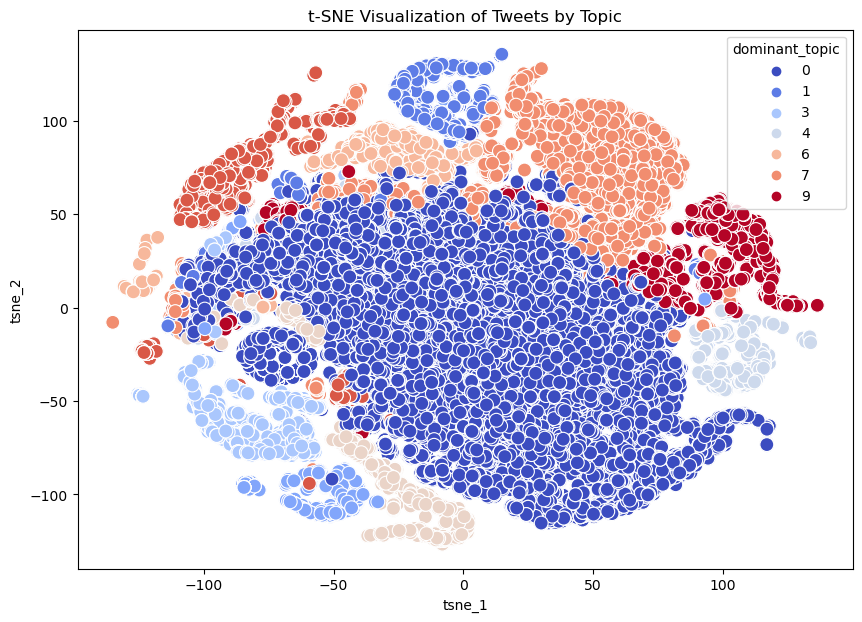

/Users/alex/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


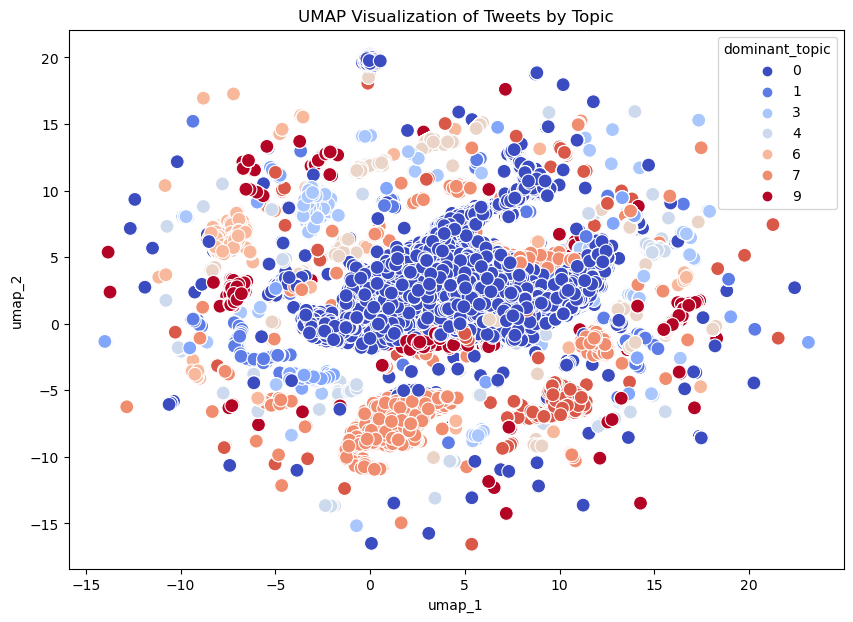

/Users/alex/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


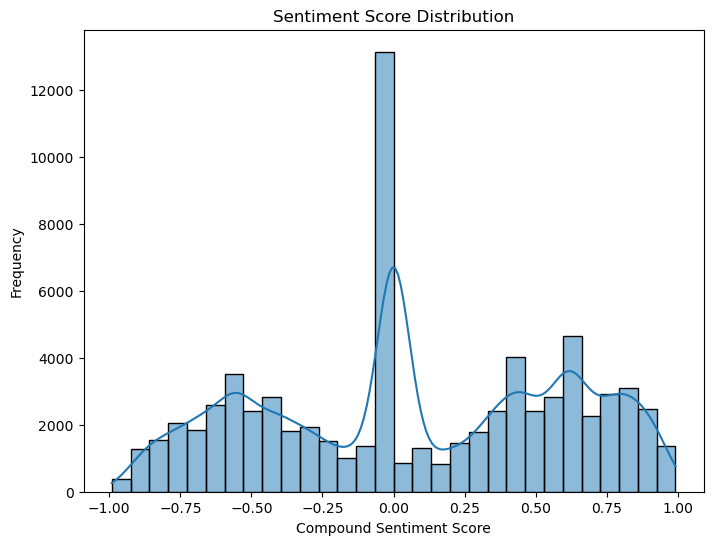

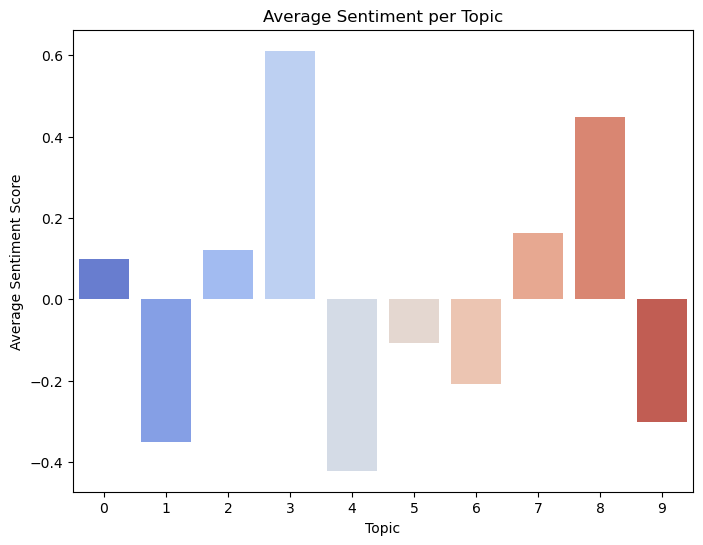

In [17]:
# Improving the model:
# Increasing n_components to see if we get more distinct topics

n_components = 10
nmf_model = NMF(n_components=n_components, random_state=42)
W = nmf_model.fit_transform(tfidf_matrix)
H = nmf_model.components_  

# Re-running topic assignment and visualizations based on new topic model

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out(), no_top_words)
train_df['dominant_topic'] = W.argmax(axis=1)

# Analysing how much each tweet contributes to each topic by saving full topic contribution matrix per tweet
topic_contributions = pd.DataFrame(W, columns=[f'Topic_{i+1}' for i in range(n_components)])
train_df = pd.concat([train_df, topic_contributions], axis=1)

# Reducing the tweet vectors (W) to 2D to visualize clusters using t-SNE dimensionality reduction
tsne_model = TSNE(n_components=2, random_state=42)
tsne_values = tsne_model.fit_transform(W)
train_df['tsne_1'] = tsne_values[:, 0]
train_df['tsne_2'] = tsne_values[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='dominant_topic', data=train_df, palette='coolwarm', s=100)
plt.title('t-SNE Visualization of Tweets by Topic')
plt.show()

# Using UMAP for better global structure visualization
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_values = umap_model.fit_transform(W)
train_df['umap_1'] = umap_values[:, 0]
train_df['umap_2'] = umap_values[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(x='umap_1', y='umap_2', hue='dominant_topic', data=train_df, palette='coolwarm', s=100)
plt.title('UMAP Visualization of Tweets by Topic')
plt.show()

# Sentiment analysis using VADER
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return analyzer.polarity_scores(text)
train_df['sentiment'] = train_df['cleaned_tweet'].apply(get_sentiment)
train_df['sentiment_compound'] = train_df['sentiment'].apply(lambda x: x['compound'])

plt.figure(figsize=(8, 6))
sns.histplot(train_df['sentiment_compound'], bins=30, kde=True)
plt.title('Sentiment Score Distribution')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Correlation between sentiment and topics - calculating average sentiment for each of the topics
avg_sentiment_per_topic = train_df.groupby('dominant_topic')['sentiment_compound'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x=avg_sentiment_per_topic.index, y=avg_sentiment_per_topic.values, palette='coolwarm')
plt.title('Average Sentiment per Topic')
plt.xlabel('Topic')
plt.ylabel('Average Sentiment Score')
plt.show()

train_df.to_csv('/Users/alex/Desktop/github_projects/sentiment-map/twitter_training_with_topics_and_sentiment.csv', index=False)

### Results and analysis

Several techniques were applied to uncover patterns, topics, and sentiment trends within the tweet dataset.

##### NMF results and topic modelling:

Non-negative matrix factorisation (NMF) was used to uncover hidden topics. After testing various values for n_components, we selected 10 topics, striking a balance between interpretability and coherence.

The topics were visualised using t-SNE and UMAP for dimensionality reduction. Both methods grouped tweets by dominant topics. Topics 0 and 1 (blue shades) are the largest clusters, indicating high engagement in these areas. Smaller, distinct clusters for topics 6, 7, and 9 suggest more focused discussions.

Each topic is characterised by dominant words, and the clustering indicates some topics have more widespread engagement in the dataset.

##### VADER results and sentiment analysis:

VADER was chosen for sentiment analysis due to its effectiveness with social media data. Sentiment scores range from -1 (very negative) to 1 (very positive), providing a quick measure of tweet polarity.

The sentiment score distribution shows peaks around -0.25 (negative) and 0.5 (positive), with a significant neutral cluster around 0. The average sentiment per topic shows that:
Topics 3 and 8 have higher positive sentiment.
Topics 1 and 9 tend to be more negative.
Topics 0, 2, and 4 are largely neutral.

##### Cluster analysis:

t-SNE and UMAP visualisations revealed clear clustering of tweets by topic, indicating that NMF effectively separated tweets into coherent groups. There is some overlap, particularly among neutral topics, but the clustering generally reflects meaningful distinctions.

Sentiment scores align well with the identified topics. For example, the most positive topics (e.g., topic 3) correlate with positive sentiment, while more negative topics (e.g., topic 9) reflect negative sentiment.

##### Evaluation metrics:

As this is an unsupervised learning task, traditional accuracy metrics are not used. However, the cluster coherence, as visualised through t-SNE and UMAP, suggests that the topic model is effective. The sentiment distribution also indicates that VADER captures tweet sentiment patterns well.

Overal there was a successful combined topic modelling and sentiment analysis here, to reveal patterns in the tweet dataset. NMF provided clear topic distinctions, while VADER captured the range of sentiments expressed. Visualisations confirm the effectiveness of these models in grouping tweets and understanding their underlying sentiment.

### Discussion and conclusion

This project identified several distinct topics within the dataset, and visualisations using t-SNE and UMAP helped us observe how these topics clustered and correlated with sentiment. The sentiment distribution showed how positive, negative or neutral the tweets were overall. 

VADER sentiment analysis provided insights into sentiment polarity and intensity. The sentiment distribution indicated a heavy concentration of neutral tweets, typical of online discourse, but distinct patterns emerged for more polarised sentiments. For example, some topics, such as topic 3, leaned heavily positive, while others, like topic 9, carried more negative sentiment. These findings reveal that certain subjects provoke stronger emotional responses on Twitter. This could be a very interesting starting point for a variety of subsequent studies, for example, looking into the proliferation patterns of topics based on the different sentiments they carry.

The model could be refined by adjusting the number of NMF components to enhance topic separation, and more advanced sentiment models could provide deeper insight into sentiment nuance.

Overall, this analysis highlights how unsupervised methods, coupled with sentiment analysis, can reveal hidden patterns in text data, offering practical insights for social media monitoring, sentiment tracking, and content strategy.

